---
title: Predictive vs. explanatory regression
teaching: 45
exercises: 2
keypoints:
- "Linear regression models can be used to predict a target variable and/or to reveal relationships between variables"
- "Linear models are most effective when applied to linear relationships. Data transformation techniques can be used to help ensure that only linear relationships are modelled."
- "Train/test splits are used to assess under/overfitting in a model"
- "Different model evaluation metrics provide different perspectives of model error. Some error measurements, such as R-squared, are not as relevant for explanatory models."
objectives:
- "Review structure and goals of linear regression"
- "Know when to use different model evaluation metrics for different modeling goals"
- "Learn how to train and evaluate a predictive machine learning model"
- "Understand how to detect underfitting and overfitting in a machine learning model"
questions:
- "What are the two different goals to keep in mind when fitting machine learning models?"
- "What kinds of questions can be answered using linear regresion?"
- "How can we evaluate a model's ability to capture a true signal/relationship in the data versus spurious noise?"
---

# Linear Regression
Linear regression is powerful technique that is often used to understand whether and how certain *predictor variables* (e.g., garage size, year built, etc.) in a dataset **linearly relate** to some *target variable* (e.g., house sale prices). Starting with linear models when working with high-dimensional data can offer several advantages including:

* **Simplicity and Interpretability**: Linear models, such as linear regression, are relatively simple and interpretable. They provide a clear understanding of how each predictor variable contributes to the outcome, which can be especially valuable in exploratory analysis.

* **Baseline Understanding**: Linear models can serve as a baseline for assessing the predictive power of individual features. This baseline helps you understand which features have a significant impact on the target variable and which ones might be less influential.

* **Feature Selection**: Linear models can help you identify relevant features by looking at the estimated coefficients. Features with large coefficients are likely to have a stronger impact on the outcome, while those with small coefficients might have negligible effects

While linear models have their merits, it's important to recognize that they might not capture complex (nonlinear) relationships present in the data. However, they are often the best option available when working in a high-dimensional context unless data is extremely limited.

##  Goals of Linear Regression
By fitting linear models to the Ames housing dataset, we can...

1. **Predict**: Use predictive modeling to predict hypothetical/future sale prices based on observed values of the predictor variables in our dataset (e.g., garage size, year built, etc.).
2. **Explain**: Use statistics to make scientific claims concerning which predictor variables have a significant impact on sale price — the target variable (a.k.a. response / dependent variable)

**Terminology note:** "target" and "predictor" synonyms
* Predictor = independent variable = feature
* Target = dependent variable = response = outcome

In this workshop, we will explore how we can exploit well-established machine learning methods, including *feature selection*, and *regularization techniques* (more on these terms later), to achieve both of the above goals on high-dimensional datasets.

#### EXERCISE_START: To predict or explain. That is the question.
When trying to model data you use in your work, which goal is typically more prevalent? Do you typically care more about (1) accurately predicting some target variable or (2) making scientific claims concerning the existence of certain relationships between variables?
#### EXERCISE_SOLUTION
In a research setting, explaining relationships typically takes higher priority over predicting since explainations hold high value in science, but both goals are sometimes relevant. In industry, the reverse is typically true as many industry applications place predictive accuracy above explainability. We will explore how these goals align and sometimes diverge from one another throughout the remaining lessons.
#### EXERCISE_END

## Predicting housing prices with a single predictor
We'll start with the first goal: prediction. How can we use regression models to predict housing sale prices? For clarity, we will begin this question through the lens of simple univariate regression models.

### General procedure for fitting and evaluating predictive models
We'll follow this general procedure to fit and evaluate predictive models:

1. **Extract predictor(s), X, and target, y, variables**
2. **Preprocess the data: check for NaNs and extreme sparsity**
3. **Visualize the relationship between X and y**
4. **Transform target variable, if necessary, to get a linear relationship between predictors**
5. **Train/test split the data**
6. **Fit the model to the training data**
7. **Evaluate model**

    a. Plot the data vs predictions - qualitative assessment
    
    b. Measure train/test set errors and check for signs of underfitting or overfitting


We'll start by loading in the Ames housing data as we have done previously in this workshop.

In [1]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto') #

### 1) Extract predictor variable and target variable from dataframe
Next, we'll extract the two variables we'll use for our model — the target variable that we'll attempt to predict (SalePrice), and a single predictor variable that will be used to predict the target variable. For this example, we'll explore how well the "OverallQual" variable (i.e., the predictor variable) can predict sale prices. 

**OverallQual**: Rates the overall material and finish of the house

       10	Very Excellent
       1	Very Poor

In [2]:
# Extract x (predictor) and y (target)
y = housing['target']
predictor = 'OverallQual'
x = housing['data'][predictor]

### 2) Preprocess the data 

In [3]:
# remove columns with nans or containing > 97% constant values (typically 0's)
from preprocessing import remove_bad_cols
x_good = remove_bad_cols(x, .9)

OverallQual: most_common_val = 7, presence = 21.85
# of columns removed: 1
Columns removed: ['OverallQual']


### 3) Visualize the relationship between x and y
Before fitting any models in a univariate context, we should first explore the data to get a sense for the relationship between the predictor variable, "OverallQual", and the response variable, "SalePrice". If this relationship does not look linear, we won't be able to fit a good linear model (i.e., a model with low average prediction error in a predictive modeling context) to the data.

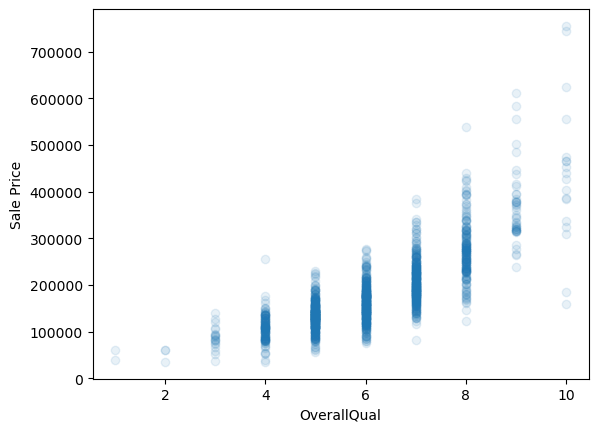

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x,y, alpha=.1)
plt.xlabel(predictor)
plt.ylabel('Sale Price');
# plt.savefig('..//fig//regression//scatterplot_x_vs_salePrice.png', bbox_inches='tight', dpi=300, facecolor='white');

<img src="../fig/regression/scatterplot_x_vs_salePrice.png"  align="center" width="30%" height="30%">

### 4) Transform target variable, if necessary
Unfortunately, sale price appears to grow almost exponentially—not linearly—with the predictor variable. Any line we draw through this data cloud is going to fail in capturing the true trend we see here. 

##### Log scaling
How can we remedy this situation? One common approach is to log transform the target variable. We’ll convert the "SalePrice" variable to its logarithmic form by using the math.log() function. Pandas has a special function called apply which can apply an operation to every item in a series by using the statement y.apply(math.log), where y is a pandas series.

In [5]:
import numpy as np
y_log = y.apply(np.log)

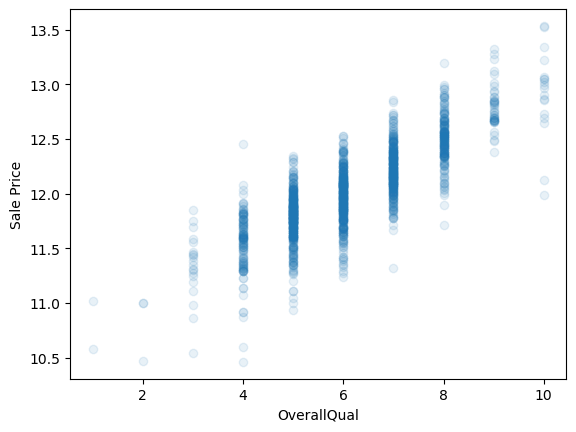

In [6]:
plt.scatter(x,y_log, alpha=.1)
plt.xlabel(predictor)
plt.ylabel('Sale Price');
# plt.savefig('..//fig//regression//scatterplot_x_vs_logSalePrice.png', bbox_inches='tight', dpi=300, facecolor='white')

<img src="../fig/regression/scatterplot_x_vs_logSalePrice.png"  align="center" width="30%" height="30%">

This plot looks much better than the previous one. That is, the trend between OverallQual and log(SalePrice) appears fairly linear. Whether or not it is sufficiently linear can be addressed when we evaluate the model's performance later.

### 5) Train/test split
Next, we will prepare two subsets of our data to be used for *model-fitting* and *model evaluation*. This process is standard for any predictive modeling task that involves a model "learning" from observed data (e.g., fitting a line to the observed data).

During the model-fitting step, we use a subset of the data referred to as **training data** to estimate the model's coefficients (the slope of the model). The univariate model will find a line of best fit through this data. 

Next, we can assess the model's ability to generalize to new datasets by measuring its performance on the remaining, unseen data. This subset of data is referred to as the **test data** or holdout set. By evaluating the model on the test set, which was not used during training, we can obtain an unbiased estimate of the model's performance.

If we were to evaluate the model solely on the training data, it could lead to **overfitting**. Overfitting occurs when the model learns the noise and specific patterns of the training data too well, resulting in poor performance on new data. By using a separate test set, we can identify if the model has overfit the training data and assess its ability to generalize to unseen samples. While overfitting is typically not likely to occur when using only a single predictor variable, it is still a good idea to use a train/test split when fitting univariate models. This can help in detecting unanticipated issues with the data, such as missing values, outliers, or other anomalies that affect the model's behavior.

![The above image is from Badillo et al., 2020. An Introduction to Machine Learning. Clinical Pharmacology & Therapeutics. 107. 10.1002/cpt.1796.](../fig/regression/under_v_over_fit.png)


The below code will split our dataset into a training dataset containing 2/3 of the samples, and a test set containing the remaining 1/3 of the data. We'll discuss these different subsets in more detail in just a bit.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_log, 
                                                    test_size=0.33, 
                                                    random_state=0)

print(x_train.shape)
print(x_test.shape)

(978,)
(482,)


Reshape single-var predictor matrix in preparation for model-fitting step (requires a 2-D representation)

In [8]:
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
print(x_train.shape)
print(x_test.shape)

(978, 1)
(482, 1)


### 6) Fit the model to the training dataset

During the model fitting step, we use a subset of the data referred to as **training data** to estimate the model's coefficients. The univariate model will find a line of best fit through this data.

##### The sklearn library
When fitting linear models solely for predictive purposes, the scikit-learn or "sklearn" library is typically used. Sklearn offers a broad spectrum of machine learning algorithms beyond linear regression. Having multiple algorithms available in the same library allows you to switch between different models easily and experiment with various techniques without switching libraries. Sklearn is also optimized for performance and efficiency, which is beneficial when working with large datasets. It can efficiently handle large-scale linear regression tasks, and if needed, you can leverage tools like NumPy and SciPy, which are well-integrated with scikit-learn for faster numerical computations.

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train,y_train)

### 7) Evaluate model
#### a) Plot the data vs predictions - qualitative assessment

In [10]:
y_pred_train=reg.predict(x_train)
y_pred_test=reg.predict(x_test)

In [11]:
from regression_predict_sklearn import plot_train_test_predictions 

?plot_train_test_predictions

Signature:
plot_train_test_predictions(
    predictors: List[str],
    X_train: Union[numpy.ndarray, pandas.core.series.Series, pandas.core.frame.DataFrame],
    X_test: Union[numpy.ndarray, pandas.core.series.Series, pandas.core.frame.DataFrame],
    y_train: Union[numpy.ndarray, pandas.core.series.Series],
    y_test: Union[numpy.ndarray, pandas.core.series.Series],
    y_pred_train: Union[numpy.ndarray, pandas.core.series.Series],
    y_pred_test: Union[numpy.ndarray, pandas.core.series.Series],
    y_log_scaled: bool,
    plot_raw: bool,
    err_type: Optional[str] = None,
    train_err: Optional[float] = None,
    test_err: Optional[float] = None,
) -> Tuple[Optional[matplotlib.figure.Figure], Optional[matplotlib.figure.Figure]]
Docstring:
Plot true vs. predicted values for train and test sets and line of best fit.

Args:
    predictors (List[str]): List of predictor names.
    X_train (Union[np.ndarray, pd.Series, pd.DataFrame]): Training feature data.
    X_test (Union[np.ndarra

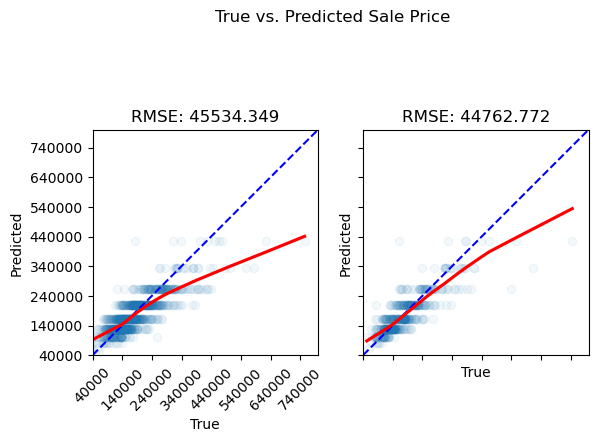

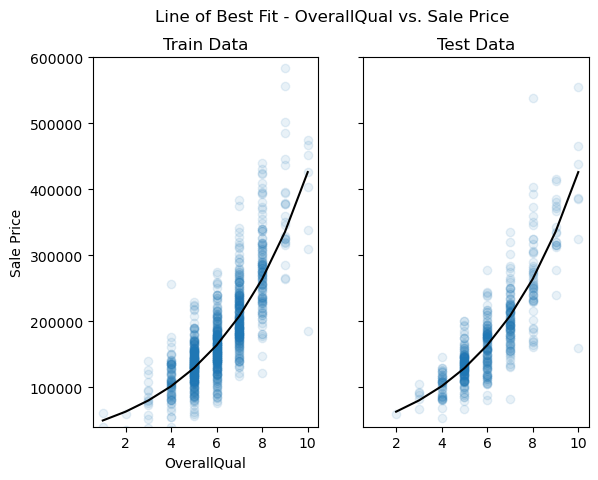

In [12]:
(fig1, fig2) = plot_train_test_predictions(predictors=[predictor],
                                           X_train=x_train, X_test=x_test,
                                           y_train=y_train, y_test=y_test,
                                           y_pred_train=y_pred_train, y_pred_test=y_pred_test,
                                           y_log_scaled=True, plot_raw=True);

# print(type(fig1))
# import matplotlib.pyplot as plt
# import pylab as pl
# pl.figure(fig1.number)
# plt.savefig('..//fig//regression//univariate_truePrice_vs_predPrice.png',bbox_inches='tight', dpi=300)
# pl.figure(fig2.number)
# fig2.savefig('..//fig//regression//univariate_x_vs_predPrice.png',bbox_inches='tight', dpi=300)


<img src="../fig/regression/univariate_truePrice_vs_predPrice.png"  align="left" width="40%" height="40%">
<img src="../fig/regression/univariate_x_vs_predPrice.png"  align="center" width="40%" height="40%">

#### EXERCISE_START: Inspect the plots
1. Does the model capture the variability in sale prices well? Would you use this model to predict the sale price of a house? Why or why not?

2. Does the model seem to exhibit any signs of overfitting? What about underfitting?

3. How might you improve the model?

#### EXERCISE_SOLUTION
1. Based on visual inspection, this linear model does a fairly good job in capturing the relationship between "OverallQual" and sale price. However, there is a tendency for the model to underpredict more expensive homes and overpredict less expensive homes. 

2. Since the train and test set plots look very similar, overfitting is not a concern. Generally speaking, overfitting is not encountered with univariate models unless you have an incredily small number of samples to train the model on. Since the model follows the trajectory of sale price reasonably well, it also does not appear to underfit the data (at least not to an extreme extent).

3. In order to improve this model, we can ask ourselves — is "OverallQual" likely the only variable that contributes to final sale price, or should we consider additional predictor variables? Most outcome variables can be influenced by more than one predictor variable. By accounting for all predictors that have an impact on sales price, we can improve the model.

#### EXERCISE_END

#### b. Measure train/test set errors and check for signs of underfitting or overfitting
While qualitative examinations of model performance are extremely helpful, it is always a good idea to pair such evaluations with a quantitative analysis of the model's performance.

**Convert back to original data scale**  
There are several error measurements that can't be used to measure a regression model's performance. Before we implement any of them, we'll first convert the log(salePrice) back to original sale price for ease of interpretation.

In [13]:
expY_train = np.exp(y_train)
pred_expY_train = np.exp(y_pred_train)

expY_test = np.exp(y_test)
pred_expY_test = np.exp(y_pred_test)

**Measure baseline performance**

In [14]:
from math import sqrt
import pandas as pd

baseline_predict = y.mean()
print('mean sale price =', baseline_predict)
# convert to series same length as y sets for ease of comparison
baseline_predict = pd.Series(baseline_predict) 
baseline_predict = baseline_predict.repeat(len(y))
baseline_predict

mean sale price = 180921.19589041095


0    180921.19589
0    180921.19589
0    180921.19589
0    180921.19589
0    180921.19589
         ...     
0    180921.19589
0    180921.19589
0    180921.19589
0    180921.19589
0    180921.19589
Length: 1460, dtype: float64

**Root Mean Squared Error (RMSE)**:
The RMSE provides an easy-to-interpret number that represents error in terms of the units of the target variable. With our univariate model, the "YearBuilt" predictor variable (a.k.a. model feature) predicts sale prices within +/- $68,106 from the true sale price. We always use the RMSE of the test set to assess the model's ability to generalize on unseen data. An extremely low prediction error in the train set is also a good indicator of overfitting.

In [15]:
from sklearn import metrics

RMSE_baseline = metrics.mean_squared_error(y, baseline_predict, squared=False) 
RMSE_train = metrics.mean_squared_error(expY_train, pred_expY_train, squared=False) 
RMSE_test = metrics.mean_squared_error(expY_test, pred_expY_test, squared=False) 

print(f"Baseline RMSE = {RMSE_baseline}")
print(f"Train RMSE = {RMSE_train}")
print(f"Test RMSE = {RMSE_test}")

Baseline RMSE = 79415.29188606751
Train RMSE = 45534.34940950763
Test RMSE = 44762.77229823455


Here, both train and test RMSE are very similar to one another. As expected with most univariate models, we do not see any evidence of overfitting. This model performs substantially better than the baseline. However, an average error of +/- $44,726 is likely too high for this model to be useful in practice. That is, the model is underfitting the data given its poor ability to predict the true housing prices. 

**Mean Absolute Percentage Error**:
What if we wanted to know the percent difference between the true sale price and the predicted sale price? For this, we can use the **mean absolute percentage error (MAPE)**...

#### Practice using helper function, `measure_model_err`
This code will be identical to the code above except for changing `metrics.mean_squared_error` to `metrics.mean_absolute_percentage_error`.

Rather than copying and pasting the code above, let's try using one of the helper functions provided for this workshop. 

In [16]:
from regression_predict_sklearn import measure_model_err
?measure_model_err

Signature:
measure_model_err(
    y: Union[numpy.ndarray, pandas.core.series.Series],
    baseline_pred: Union[float, numpy.float64, numpy.float32, int, numpy.ndarray, pandas.core.series.Series],
    y_train: Union[numpy.ndarray, pandas.core.series.Series],
    y_pred_train: Union[numpy.ndarray, pandas.core.series.Series],
    y_test: Union[numpy.ndarray, pandas.core.series.Series],
    y_pred_test: Union[numpy.ndarray, pandas.core.series.Series],
    metric: str,
    y_log_scaled: bool,
) -> pandas.core.frame.DataFrame
Docstring:
Measures the error of a regression model's predictions on train and test sets.

Args:
    y (Union[np.ndarray, pd.Series]): Actual target values for full dataset (not transformed)
    baseline_pred (Union[float, np.float64, np.float32, int, np.ndarray, pd.Series]): Single constant or array of predictions equal to the length of y. Baseline is also not transformed.
    y_train (Union[np.ndarray, pd.Series]): Actual target values for the training set.
    y_pred

In [17]:
error_df = measure_model_err(y=y, baseline_pred=baseline_predict,
                                                         y_train=expY_train, y_pred_train=pred_expY_train, 
                                                         y_test=expY_test, y_pred_test=pred_expY_test, 
                                                         metric='MAPE', y_log_scaled=False) 

error_df.head()

,Baseline Error,Train Error,Test Error
0,0.363222,0.187585,0.16754


With the MAPE measurement (max value of 1 which corresponds to 100%), we can state that our model over/under estimates sale prices by an average of 23.41% (25.28%) across all houses included in the test set (train set). Certainly seems there is room for improvement based on this measure.

**R-Squared**: Another useful error measurement to use with regression models is the coefficient of determination — $R^2$. Oftentimes pronounced simply "R-squared",  this measure assesses the proportion of the variation in the target variable that is predictable from the predictor variable(s). Using sklearn's metrics, we can calculate this as follows:

In [18]:
error_df = measure_model_err(y=y, baseline_pred=baseline_predict,
                                                   y_train=expY_train, y_pred_train=pred_expY_train, 
                                                   y_test=expY_test, y_pred_test=pred_expY_test, 
                                                   metric='R-squared', y_log_scaled=False) 

error_df.head()

,Baseline Error,Train Error,Test Error
0,0.0,0.666875,0.690463


Our model predicts 70.1% (65.2%) of the variance across sale prices in the test set (train set). The R-squared for the baseline model is 0 because the numerator and denominator in the equation for R-squared are equivalent:

### R-squared equation: R-squared = 1 - (Sum of squared residuals) / (Total sum of squares)

**Sum of Squared Residuals (SSR)**:
SSR = Sum of (Actual Value - Predicted Value)^2 for all data points. The Sum of Squared Residuals (SSR) is equivalent to the variance of the residuals in a regression model. Residuals are the differences between the actual observed values and the predicted values produced by the model. Squaring these differences and summing them up yields the SSR.

**Total Sum of Squares (TSS)**:
TSS = Sum of (Actual Value - Mean of Actual Values)^2 for all data points. The TSS represents the total variability or dispersion in the observed values of the target variable. It measures the total squared differences between each data point's value and the mean of the observed values.

To read more about additional error/loss measurements, visit [sklearn's metrics documentation](https://scikit-learn.org/stable/modules/model_evaluation.html).

#### EXERCISE_START: More on R-squared
Our above example model is able to explain roughly 70.1% of the variance in the test dataset. Is this a “good” value for R-squared?

#### EXERCISE_SOLUTION
The answer to this question depends on your objective for the regression model. This relates back to the two modeling goals of *explaining* vs *predicting*. Depending on the objective, the answer to "What is a good value for R-squared?" will be different.

**Predicting the response variable:**
If your main objective is to predict the value of the response variable accurately using the predictor variable, then R-squared is important. The value for R-squared can range from 0 to 1. A value of 0 indicates that the response variable cannot be explained by the predictor variable at all. A value of 1 indicates that the response variable can be perfectly explained without error by the predictor variable. In general, the larger the R-squared value, the more precisely the predictor variables are able to predict the value of the response variable. How high an R-squared value needs to be depends on how precise you need to be for your specific model's application. To find out what is considered a “good” R-squared value, you will need to explore what R-squared values are generally accepted in your particular field of study.

**Explaining the relationship between the predictor(s) and the response variable:**
If your main objective for your regression model is to explain the relationship(s) between the predictor(s) and the response variable, the R-squared is mostly irrelevant. A predictor variable that consistently relates to a change in the response variable (i.e., has a statistically significant effect) is typically always interesting — regardless of the the effect size. The exception to this rule is if you have a near-zero R-squared, which suggests that the model does not explain any of the variance in the data.

#### EXERCISE_END

## Comparing univariate predictive models
Let's see how well the other predictors in our dataset can predict sale prices. For simplicity, we'll compare just continous predictors for now. 

### General procedure for comparing predictive models
We'll follow this general procedure to compare models:

1. Use get_feat_types() to get a list of continuous predictors
2. Create an X variable containing only continuous predictors from `housing['data']`
3. Extract sale prices from `housing['target']` and log scale it
4. Use the remove_bad_cols helper function to remove predictors with nans or containing > 97% constant values (typically 0's)
5. Perform a train/validation/test split using 60% of the data to train, 20% for validation (model selection), and 20% for final testing of the data
6. Use the `compare_models` helper function to quickly calculate train/validation errors for all possible single predictors. Returns a `df_model_err` df that contains the following data stored for each predictor: 'Predictor Variable', 'Train Error', 'Validation Error'.

In [19]:
# preprocess
from preprocessing import get_feat_types
predictor_type_dict = get_feat_types()
continuous_fields = predictor_type_dict['continuous_fields']
X = housing['data'][continuous_fields]
y_log = np.log(housing['target'])

# remove columns with nans or containing > 97% constant values (typically 0's)
from preprocessing import remove_bad_cols
X_good = remove_bad_cols(X, 99)

LotFrontage: removed due to 259 NaNs
MasVnrArea: removed due to 8 NaNs
GarageYrBlt: removed due to 81 NaNs
PoolArea: most_common_val = 0, presence = 99.52
# of columns removed: 4
Columns removed: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'PoolArea']


In [20]:
# train/holdout split
X_train, X_holdout, y_train, y_holdout = train_test_split(X_good, y_log, 
                                                          test_size=0.4, 
                                                          random_state=0)

# validation/test split
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, 
                                                test_size=0.5, 
                                                random_state=0)

In [21]:
from regression_predict_sklearn import compare_models
?compare_models

Signature:
compare_models(
    y: Union[numpy.ndarray, pandas.core.series.Series],
    baseline_pred: Union[numpy.ndarray, pandas.core.series.Series],
    X_train: pandas.core.frame.DataFrame,
    y_train: Union[numpy.ndarray, pandas.core.series.Series],
    X_val: pandas.core.frame.DataFrame,
    y_val: Union[numpy.ndarray, pandas.core.series.Series],
    predictors_list: List[List[str]],
    metric: str,
    y_log_scaled: bool,
    model_type: str,
    include_plots: bool,
    plot_raw: bool,
    verbose: bool,
) -> pandas.core.frame.DataFrame
Docstring:
Compare different models based on predictor variables and evaluate their errors.

Args:
    y (Union[np.ndarray, pd.Series]): Target variable in its original scale (raw/untransformed).
    baseline_pred (Union[np.ndarray, pd.Series]): Baseline predictions (in same scale as original target, y).
    X_train (pd.DataFrame): Training feature data.
    y_train (Union[np.ndarray, pd.Series]): Actual target values for the training set.
    

In [22]:
df_model_err = compare_models(y=y, baseline_pred=baseline_predict,
                              X_train=X_train, y_train=y_train, 
                              X_val=X_val, y_val=y_val,
                              predictors_list=X_train.columns, 
                              metric='RMSE', y_log_scaled=True, 
                              model_type='unregularized', 
                              include_plots=False, plot_raw=False, verbose=False)

df_model_err.head()

,Baseline Error,Train Error,Validation Error,Predictors
0,79415.291886,82875.380855,84323.189234,LotArea
1,79415.291886,67679.790920,69727.341057,YearBuilt
2,79415.291886,69055.741014,70634.285653,YearRemodAdd
3,79415.291886,45516.185542,46993.501006,OverallQual
4,79415.291886,81016.566207,84915.452252,OverallCond


Best model train error = 45516.18554163278
Best model validation error = 46993.501005708364
Worst model train error = 63479.544551733954
Worst model validation error = 220453.4404000341


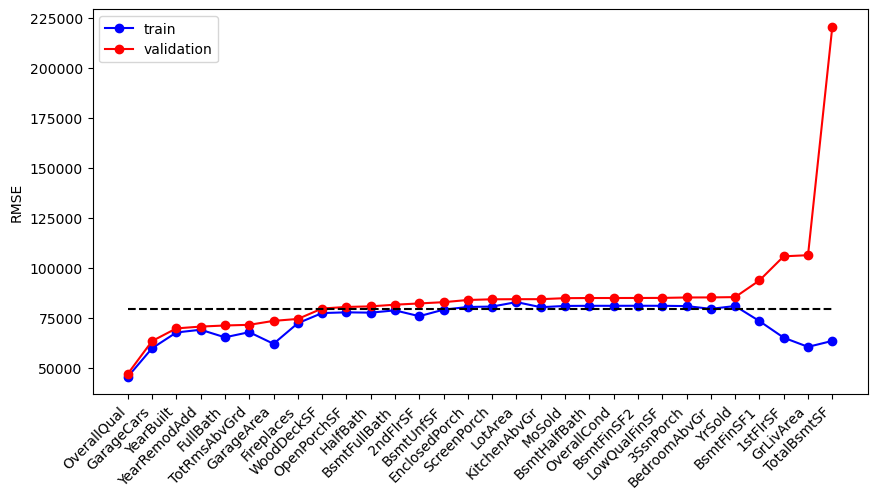

In [23]:
from regression_predict_sklearn import compare_models_plot
sorted_predictors, train_errs, val_errs = compare_models_plot(df_model_err, 'RMSE');

### Examing the worst performers

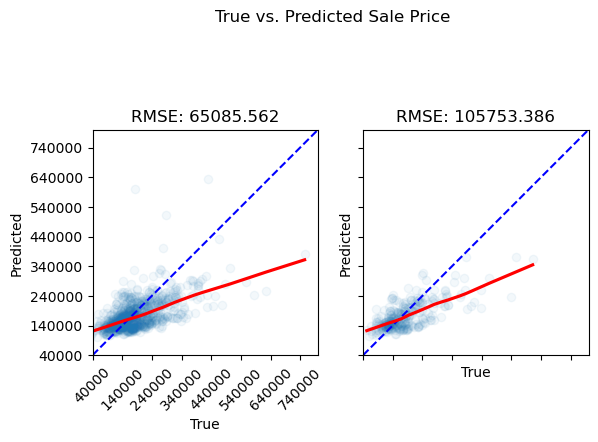

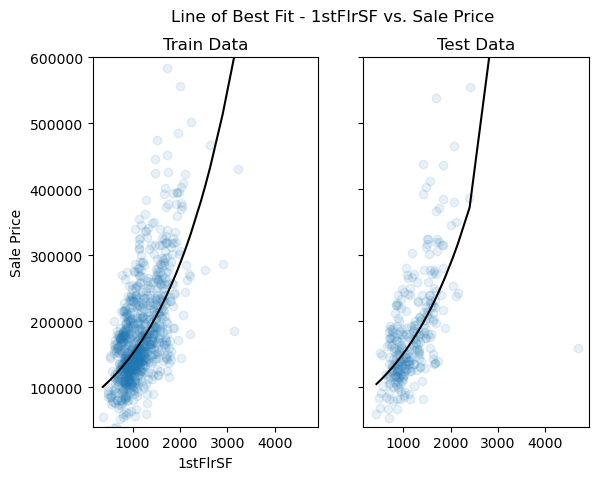

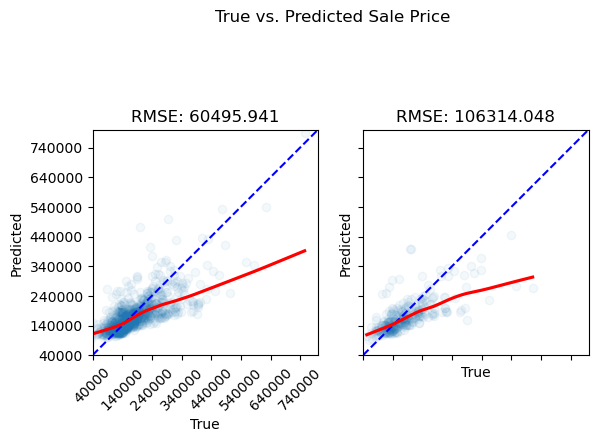

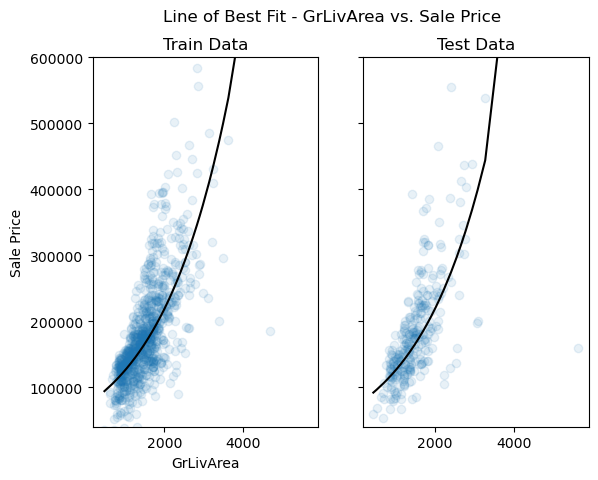

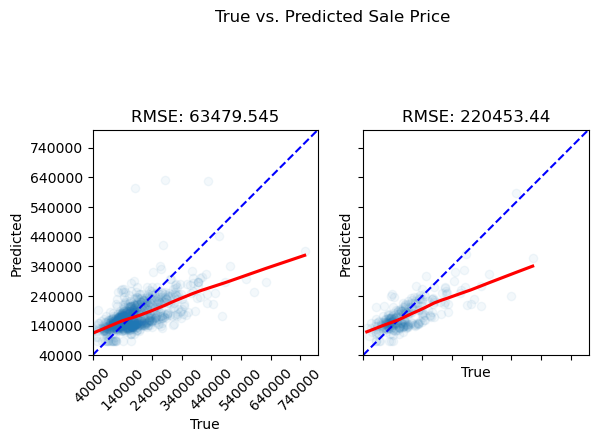

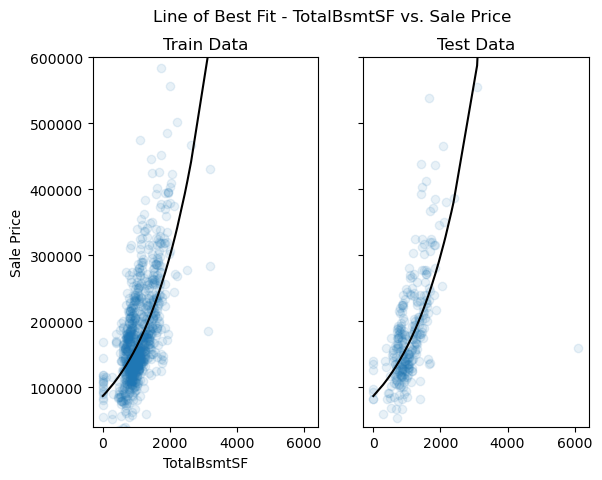

,Baseline Error,Train Error,Validation Error,Predictors
0,79415.291886,65085.562455,105753.386038,1stFlrSF
1,79415.291886,60495.941297,106314.048186,GrLivArea
2,79415.291886,63479.544552,220453.440400,TotalBsmtSF


In [24]:
df_model_err = compare_models(y=y, baseline_pred=baseline_predict,
                              X_train=X_train, y_train=y_train, 
                              X_val=X_val, y_val=y_val,
                              predictors_list=sorted_predictors[-3:], 
                              metric='RMSE', y_log_scaled=True, 
                              model_type='unregularized', 
                              include_plots=True, plot_raw=True, verbose=False)

df_model_err.head()

#### Outliers and interactions
It appears the worst performing predictors do not have much of a linear relationship with log(salePrice) and have some extreme outliers in the test set data. If we were only to focus on univariate models, we would want to remove these outliers after carefully considering their meaning and cause. However, outliers in a univariate context may not remain outliers in a multivariate context. 

This point is further illustrated by the distributions / data clouds we see with the TotalBsmtSF predictor. The type of basement finish may change the relationship between TotalBsmtSF and SalePrice. If we fit a regression model that accounts for this interaction, the model will follow a linear pattern for each distribtuion separately. Similarly, certain outliers may stem from other predictors having interactions/relationships with one another. When searching for outliers, it is important to consider such multivariate interactions.

### Fitting all predictors
Let's assume all predictors in the Ames housing dataset are related to at least some extent to sale price, and fit a multivariate regression model using all continuous predictors.

# of predictor vars = 30
# of train observations = 876
# of test observations = 292
Baseline RMSE = 79415.29188606751
Train RMSE = 34139.3449119712
Holdout RMSE = 134604.1997549234
(Holdout-Train)/Train: 294%


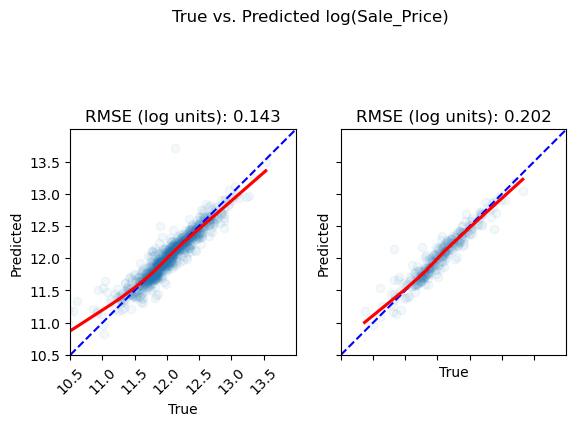

In [27]:
df_model_err = compare_models(y=y, baseline_pred=baseline_predict,
                              X_train=X_train, y_train=y_train, 
                              X_val=X_val, y_val=y_val,
                              predictors_list=[X_train.columns], 
                              metric='RMSE', y_log_scaled=True, 
                              model_type='unregularized', 
                              include_plots=True, plot_raw=False, verbose=True)


### Compare permutations of models with different numbers of predictors

In [28]:
X_train.head()
X_train.shape

(876, 30)

In [33]:
from regression_predict_sklearn import get_predictor_combos
sampled_combinations = get_predictor_combos(X_train=X_train, K=2, n=30)
print(sampled_combinations[0:2])

[['2ndFlrSF', 'GarageCars'], ['Fireplaces', 'WoodDeckSF']]


#### Compare efficacy of different numbers of predictors
To quickly assess how well we can predict sale price with varying numbers of predictors, use the code we just prepared in conjunction with a for loop to determine the best train/validation errors possible when testing 30 permutations containing K=1, 2, 5, 10, and 25 predictors. Plot the results (K vs train/test errors). Is there any trend?

K = 1
Best model train error = 59791.540810726234
Best model validation error = 63397.45129071621
Worst model train error = 63479.544551733954
Worst model validation error = 220453.4404000341


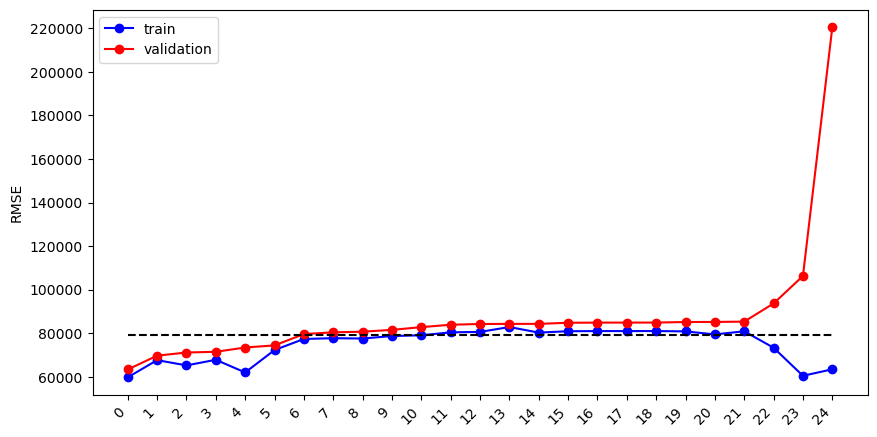

K = 2
Best model train error = 45412.486097791
Best model validation error = 46671.22187234466
Worst model train error = 63915.6512949506
Worst model validation error = 238255.72357163005


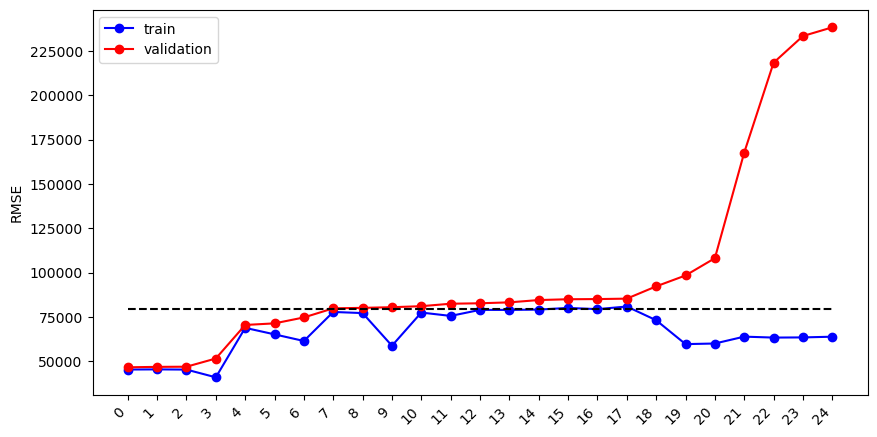

K = 5
Best model train error = 40892.18656082118
Best model validation error = 51117.9280299162
Worst model train error = 51162.12813413476
Worst model validation error = 278020.83867677924


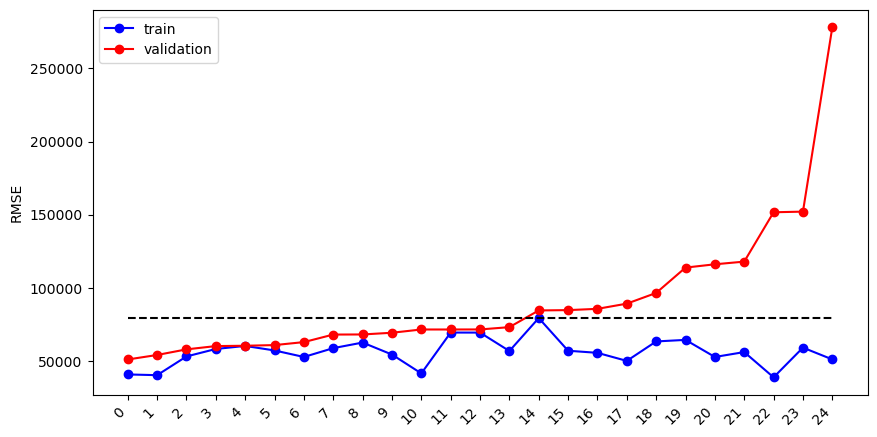

K = 10
Best model train error = 37310.283011071675
Best model validation error = 47850.00646318061
Worst model train error = 62282.26136722979
Worst model validation error = 407907.25593616534


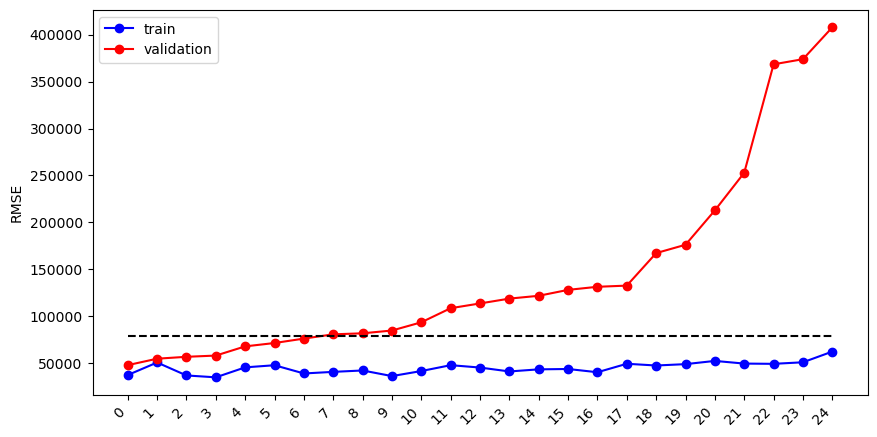

K = 20
Best model train error = 38590.76358858509
Best model validation error = 91350.83460324538
Worst model train error = 44273.749573455105
Worst model validation error = 232478.87909245736


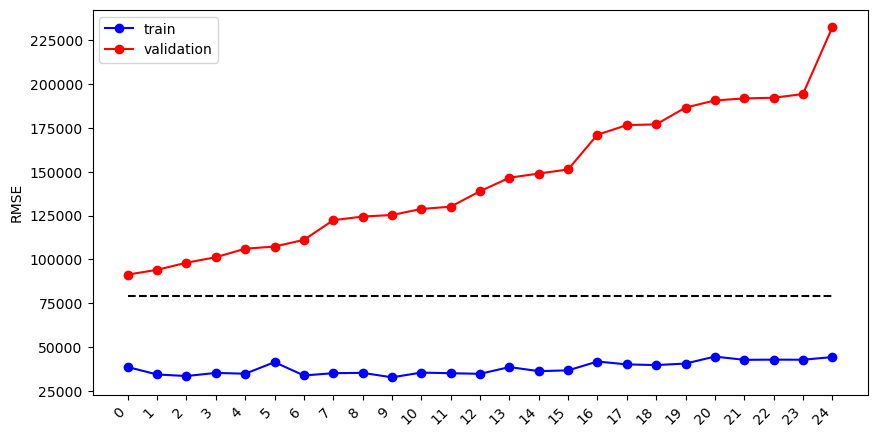

K = 25
Best model train error = 33944.16140505309
Best model validation error = 116036.64983057066
Worst model train error = 38695.35301462394
Worst model validation error = 188438.1815700615


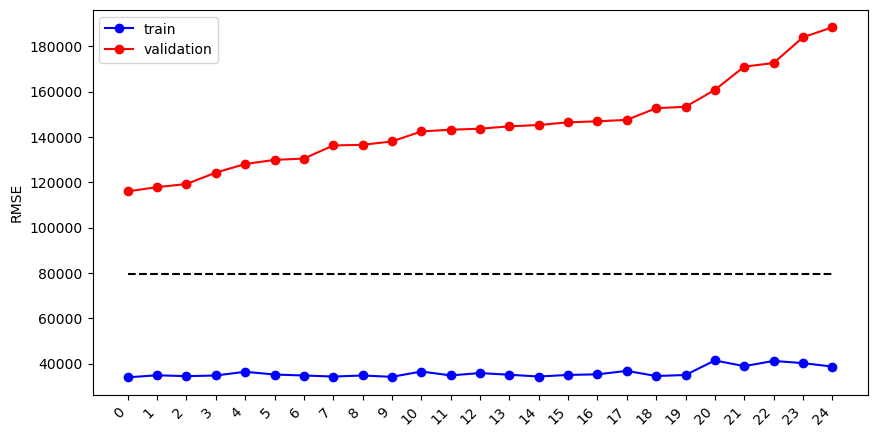

In [35]:
best_train_errs = []
best_val_errs = []
n_predictors  = [1, 2, 5, 10, 20, 25]

for K in n_predictors:
    print('K =', K)
    sampled_combinations = get_predictor_combos(X_train=X_train, K=K, n=25)
    df_model_err = compare_models(y=y, baseline_pred=baseline_predict,
                                  X_train=X_train, y_train=y_train, 
                                  X_val=X_val, y_val=y_val,
                                  predictors_list=sampled_combinations, 
                                  metric='RMSE', y_log_scaled=True, 
                                  model_type='unregularized', 
                                  include_plots=False, plot_raw=True, verbose=False)

    sorted_predictors, train_errs, val_errs = compare_models_plot(df_model_err, 'RMSE')
    best_train_errs.append(np.median(train_errs))
    best_val_errs.append(np.median(val_errs))

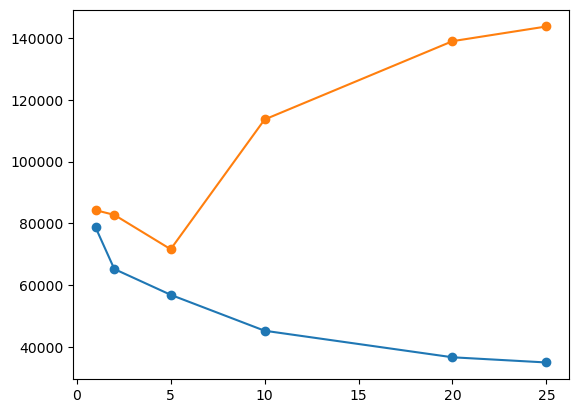

In [36]:
plt.plot(n_predictors, best_train_errs, '-o')
plt.plot(n_predictors, best_val_errs, '-o')

#### How much data is needed per new predictor? 10X rule of thumb
As the number of observations begins to approach the number of model parameters (i.e., coefficients being estimated), the model will simply memorize the training data rather than learn anything useful. As a general rule of thumb, obtaining reliable estimates from linear regression models requires that you have at least 10X as many observations than model coefficients/predictors. The exact ratio may change depending on the variability of your data and whether or not each observation is truly independent (time-series models, for instance, often require much more data since observations are rarely independent).

Let's see what the ratio is when we start to hit overfitting effects with our data. We need to determine the number of observations used to train the model as well as the number of estimated coefficients from the model (equal to number of predictors in this simple regression equation).

In [37]:
[X_train.shape[0] / n for n in n_predictors]

[876.0, 438.0, 175.2, 87.6, 43.8, 35.04]

With our data, we start to see overfitting effects even when we have as much as 87.6 times as many observations as estimated model coefficients. if you find that your regression model is more prone to overfitting that the "10X rule", it could suggest that the training data might not be strictly independently and identically distributed (i.i.d.). Overfitting occurs when a model learns the noise and random fluctuations in the training data instead of the true underlying patterns, leading to poor generalization to new data.

The reasons for overfitting can vary including:

* Data Structure: If your data has inherent structure or dependencies that violate the i.i.d. assumption (e.g., temporal or spatial dependencies), your model might capture these patterns as noise and overfit to them.
* Outliers and Noise: If your data contains outliers or noisy observations, these can influence the model's behavior and contribute to overfitting. This can be especially problematic with small datasets.

#### 7) Explaining models
At this point, we have assessed the predictive accuracy of our model. However, what if we want to interpret our model to understand which predictor(s) have a consistent or above chance (i.e., statistically significant) impact sales price? For this kind of question and other questions related to model interpretability, we need to first carefully validate our model. The next two episodes will explore some of the necessary checks you must perform before reading too far into your model's estimations.
